In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
# import pdb
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from get_mods import DART_Net, sep_ijkl_dataset

device = "cuda"

## Create DART Model

In [2]:
DART_model = DART_Net(128, 128, 256, 128, 32).to(device)

def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

DART_model.apply(init_params)

DART_Net(
  (fi1): Linear(in_features=3, out_features=128, bias=True)
  (fi2): Linear(in_features=128, out_features=128, bias=True)
  (fj1): Linear(in_features=3, out_features=128, bias=True)
  (fj2): Linear(in_features=128, out_features=128, bias=True)
  (fk1): Linear(in_features=3, out_features=128, bias=True)
  (fk2): Linear(in_features=128, out_features=128, bias=True)
  (fl1): Linear(in_features=3, out_features=128, bias=True)
  (fl2): Linear(in_features=128, out_features=128, bias=True)
  (inter1): Linear(in_features=128, out_features=256, bias=True)
  (inter2): Linear(in_features=256, out_features=128, bias=True)
  (inter3): Linear(in_features=128, out_features=32, bias=True)
  (inter4): Linear(in_features=32, out_features=1, bias=True)
  (mask): Linear(in_features=128, out_features=128, bias=False)
)

## Pre-processing of data

In [3]:
desc_data = sep_ijkl_dataset("../../../data/small_dataset.npz")

## Create Train:Validation:Test split  and dataloaders

In [4]:
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(desc_data)
indices = list(range(dataset_size))
splitv = int(np.floor(validation_split * dataset_size))
splitt = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[splitt+splitv:], indices[:splitv], indices[splitv:splitt+splitv]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(desc_data, batch_size=32, sampler=train_sampler)
validloader = DataLoader(desc_data, batch_size=32, sampler=valid_sampler)
testloader = DataLoader(desc_data, batch_size=32, sampler=test_sampler)

In [5]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(DART_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=25, verbose=True, eps=1e-09)

## Training loop

In [6]:
epochal_train_losses = []
epochal_val_losses  = []
num_epochs = 1500
epoch_freq = 1
       
def test(DART_model, testloader):
    mae = torch.nn.L1Loss()
    rmse = torch.nn.MSELoss()
    pred_energy = torch.tensor([], device="cuda")
    real_energy = torch.tensor([], device="cuda")
    cluster_size = torch.tensor([], device="cuda")
    DART_model.eval()
    with torch.no_grad():
        for batch in testloader:
            energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1).squeeze(dim=1)
            pred_energy = torch.cat((pred_energy, energy))
            real_energy = torch.cat((real_energy, batch["energy"]))
            cluster_size = torch.cat((cluster_size, batch["atm_i"][:,0].sum(axis=1)))
        results = torch.stack((cluster_size, real_energy, pred_energy), axis=1)
        test_loss = mae(pred_energy, real_energy)
        rmse_loss = torch.sqrt(rmse(pred_energy, real_energy))
        print("Test MAE = ", test_loss.item(), "Test RMSE = ", rmse_loss.item())
        return results, test_loss, rmse_loss
    
def train(DART_model, optimizer, epochal_train_losses, criterion):
    train_loss = 0.00
    n = 0
    DART_model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
        energy = energy.sum(axis=1)
        batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu()
        n += 1
    train_loss /= n
    epochal_train_losses.append(train_loss)

def train_and_evaluate(DART_model, optimizer, scheduler, criterion, start_epoch=1, restart=None):
    if restart:
        restore_path = os.path.join(log_dir + "/last.pth.tar")
        checkpoint = load_checkpoint(restore_path, DART_model, optimizer)
        start_epoch = checkpoint["epoch"]

    best_val = 100000.00
    early_stopping_learning_rate = 1.0E-8
    
    for epoch in range(1, num_epochs+1):
        learning_rate = optimizer.param_groups[0]['lr']
        if learning_rate < early_stopping_learning_rate:
            break

        ############ training #############
        train(DART_model, optimizer, epochal_train_losses, criterion)
        
        ############ validation #############
        n=0
        val_loss = 0.0
        DART_model.eval()
        for batch in validloader:
            energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1)
            batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
            val_loss += batch_loss.detach().cpu()
            n += 1
        val_loss /= n
        epochal_val_losses.append(val_loss)
        scheduler.step(val_loss)
     
        is_best = val_loss <= best_val
        if epoch % epoch_freq == 0:
            print("Epoch: {: <5} Train: {: <20} Val: {: <20}".format(epoch, epochal_train_losses[-1], val_loss))

## Let's start training

In [7]:
train_and_evaluate(DART_model, optimizer, scheduler, criterion)

Epoch: 1     Train: 607.5888061523438    Val: 98.2199935913086    
Epoch: 2     Train: 154.45396423339844   Val: 114.55366516113281  
Epoch: 3     Train: 113.06208038330078   Val: 105.64413452148438  
Epoch: 4     Train: 91.88636779785156    Val: 79.17213439941406   
Epoch: 5     Train: 92.08629608154297    Val: 100.1849594116211   
Epoch: 6     Train: 80.32140350341797    Val: 70.15669250488281   
Epoch: 7     Train: 82.54194641113281    Val: 64.58738708496094   
Epoch: 8     Train: 83.78430938720703    Val: 60.843116760253906  
Epoch: 9     Train: 72.4614028930664     Val: 72.23690032958984   
Epoch: 10    Train: 75.03366088867188    Val: 67.89266967773438   
Epoch: 11    Train: 69.69514465332031    Val: 56.97750473022461   
Epoch: 12    Train: 75.38196563720703    Val: 53.610084533691406  
Epoch: 13    Train: 61.73081970214844    Val: 70.0972900390625    
Epoch: 14    Train: 77.32492065429688    Val: 81.3260269165039    
Epoch: 15    Train: 61.460914611816406   Val: 55.5780143737793

Epoch: 124   Train: 18.01376724243164    Val: 9.578516006469727   
Epoch: 125   Train: 16.784500122070312   Val: 14.237857818603516  
Epoch: 126   Train: 16.548280715942383   Val: 13.644103050231934  
Epoch: 127   Train: 15.850751876831055   Val: 9.539752006530762   
Epoch: 128   Train: 15.491607666015625   Val: 10.4926118850708    
Epoch: 129   Train: 20.16929817199707    Val: 22.875381469726562  
Epoch: 130   Train: 18.072776794433594   Val: 9.820626258850098   
Epoch: 131   Train: 18.898061752319336   Val: 14.741153717041016  
Epoch: 132   Train: 22.14443588256836    Val: 14.820761680603027  
Epoch: 133   Train: 21.544261932373047   Val: 22.468612670898438  
Epoch: 134   Train: 15.687050819396973   Val: 21.19601058959961   
Epoch: 135   Train: 19.04374885559082    Val: 13.310157775878906  
Epoch: 136   Train: 15.992230415344238   Val: 8.433335304260254   
Epoch: 137   Train: 18.844850540161133   Val: 23.402484893798828  
Epoch: 138   Train: 19.87254524230957    Val: 15.8121337890625

Epoch: 246   Train: 5.031068801879883    Val: 5.464229106903076   
Epoch: 247   Train: 4.920995712280273    Val: 4.835978031158447   
Epoch: 248   Train: 4.760519981384277    Val: 5.230434417724609   
Epoch: 249   Train: 4.752709865570068    Val: 4.523773670196533   
Epoch: 250   Train: 4.722417831420898    Val: 4.720516204833984   
Epoch: 251   Train: 4.744997501373291    Val: 5.872957706451416   
Epoch: 252   Train: 4.9619526863098145   Val: 6.001497268676758   
Epoch: 253   Train: 4.732927322387695    Val: 6.591241359710693   
Epoch: 254   Train: 4.864285945892334    Val: 5.198471546173096   
Epoch: 255   Train: 4.556281566619873    Val: 4.70335578918457    
Epoch: 256   Train: 4.739108562469482    Val: 4.367654800415039   
Epoch: 257   Train: 4.422621726989746    Val: 5.35255241394043    
Epoch: 258   Train: 4.572192192077637    Val: 5.5058135986328125  
Epoch: 259   Train: 4.595459461212158    Val: 4.316839218139648   
Epoch: 260   Train: 4.5155816078186035   Val: 8.36296939849853

Epoch: 369   Train: 4.023162841796875    Val: 5.487575054168701   
Epoch: 370   Train: 4.143050670623779    Val: 4.299886703491211   
Epoch: 371   Train: 4.0352325439453125   Val: 4.092097759246826   
Epoch: 372   Train: 4.055702209472656    Val: 3.819758892059326   
Epoch: 373   Train: 3.9091553688049316   Val: 4.917862892150879   
Epoch: 374   Train: 4.265767574310303    Val: 6.550236225128174   
Epoch: 375   Train: 4.042303085327148    Val: 4.115718841552734   
Epoch: 376   Train: 4.070257186889648    Val: 4.5451836585998535  
Epoch: 377   Train: 3.929753303527832    Val: 3.8309597969055176  
Epoch: 378   Train: 4.01661491394043     Val: 5.085158348083496   
Epoch   379: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 379   Train: 4.186267852783203    Val: 4.0551910400390625  
Epoch: 380   Train: 3.4834485054016113   Val: 4.308248996734619   
Epoch: 381   Train: 3.477229356765747    Val: 3.755924701690674   
Epoch: 382   Train: 3.4715535640716553   Val: 3.757484197616577   


Epoch: 489   Train: 3.373183488845825    Val: 3.7305495738983154  
Epoch: 490   Train: 3.3711180686950684   Val: 3.747110605239868   
Epoch: 491   Train: 3.3767194747924805   Val: 3.7233726978302     
Epoch: 492   Train: 3.3702096939086914   Val: 3.732041835784912   
Epoch: 493   Train: 3.372589111328125    Val: 3.740840435028076   
Epoch: 494   Train: 3.371333599090576    Val: 3.729280948638916   
Epoch: 495   Train: 3.372044086456299    Val: 3.7245073318481445  
Epoch: 496   Train: 3.36892032623291     Val: 3.7331926822662354  
Epoch: 497   Train: 3.375018358230591    Val: 3.7234134674072266  
Epoch   498: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 498   Train: 3.369493007659912    Val: 3.7300522327423096  
Epoch: 499   Train: 3.373936653137207    Val: 3.728707790374756   
Epoch: 500   Train: 3.3711416721343994   Val: 3.7249109745025635  
Epoch: 501   Train: 3.3715503215789795   Val: 3.730403184890747   
Epoch: 502   Train: 3.3716886043548584   Val: 3.7267305850982666  


## Testing the model on unseen data (test-set)

In [8]:
results, test_mae, test_rmse = test(DART_model, testloader)

Test MAE =  3.749802350997925 Test RMSE =  4.892120838165283


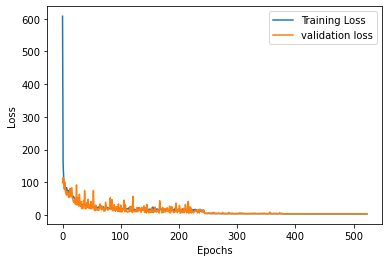

In [9]:
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_train_losses, label='Training Loss')
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_val_losses, label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

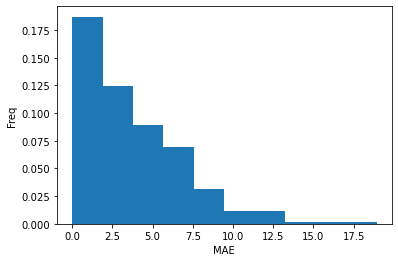

In [10]:
results = results[results[:,0].argsort()].cpu().numpy()
plt.hist(abs(results[:,1]-results[:,2]), density=True)
plt.xlabel("MAE")
plt.ylabel("Freq")
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

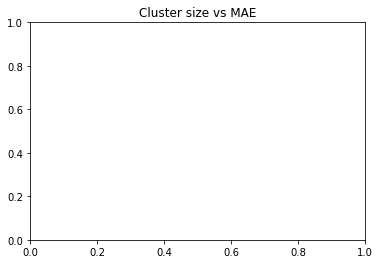

In [11]:
some_res = np.split(results[:,1:], np.unique(results[:, 0], return_index=True)[1][1:])
diff = [abs(i[:,0]-i[:,1]).mean() for i in some_res]
plt.title("Cluster size vs MAE")
plt.bar(np.arange(31, 41), diff, label='Training Loss')
plt.xlabel("Cluster size")
plt.ylabel("MAE")
plt.show()

In [ ]:
trainset = desc_data[train_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Train set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=10)
plt.show()
# plt.savefig("cluster_distribution_trainset.png", bbox_inches='tight')

In [ ]:
trainset = desc_data[test_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Test set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=10)
plt.show()
# plt.savefig("cluster_distribution_testset.png", bbox_inches='tight')

In [ ]:
trainset = desc_data[val_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Validation set Cluster distribution, size = {}".format(len(sizzle)))
plt.hist(sizzle, bins=10)
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.show()
# plt.savefig("cluster_distribution_validationset.png", bbox_inches='tight')